In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from tqdm import tqdm

# Importar utils
sys.path.append('..')
from utils import ising_data_builder, H5IsingDataset



# recontronstrucción 
Queremos pasar de una tarea de clasificación de fase (una etiqueta por configuración) a una tarea de inpainting / imputación: ocultar deliberadamente un pequeño porcentaje de spins (ej. 5%) y entrenar un modelo para predecir las posiciones ocultas. Con esto medimos cuánto el modelo ha aprendido las correlaciones del sistema y usamos la dificultad de reconstrucción para detectar propiedades físicas 



## Construcción del Dataset y train / test split



In [2]:
# Configurar ruta de datos
data = '../data/data_30/'


# Crear el dataset
data = ising_data_builder(data, kind='inpainting').h5_path
dataset = H5IsingDataset(data)

n = len(dataset)

# Train / Test Split 
train_idx, test_idx = train_test_split(
    np.arange(n),
    test_size=0.2,
    random_state=4
)

# Subsets que no copian datos, solo crean vistas por índices
train_set = Subset(dataset, train_idx.tolist())
test_set = Subset(dataset, test_idx.tolist())

# DataLoaders -> genera los batches
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)

In [3]:
# dataset.close()

## Modelo 

In [4]:
n = 30  # Tamaño del lattice 

# Bloques de la u-net
class DoubleConv(nn.Module):
    """Conv2d → BN → ReLU → Conv2d → BN → ReLU"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    """MaxPool + DoubleConv"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )
    def forward(self, x):
        return self.net(x)

class Up(nn.Module):
    """Upsample + Conv + DoubleConv"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Padding si las dimensiones no coinciden por divisiones impares
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(
            x1,
            [diffX // 2, diffX - diffX // 2,
             diffY // 2, diffY - diffY // 2]
        )

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """Última capa (sin sigmoide porque se usa BCEWithLogitsLoss)"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# U-NET
class UNetIsing(nn.Module):
    def __init__(self, n_channels=1, out_channels=1):
        super().__init__()

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)

        self.up1 = Up(512, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)

        self.outc = OutConv(64, out_channels)

    def forward(self, x):
        if x.dim() == 3:  # (batch, n, n)
            x = x.unsqueeze(1)

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)

        x = self.up1(x4, x3)
        x = self.up2(x,  x2)
        x = self.up3(x,  x1)

        logits = self.outc(x)   # (batch, 1, n, n)
        return logits

# Inicialización del modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetIsing(n_channels=2, out_channels=1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
# Cargar modelo entrenado

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetIsing(n_channels=2, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Cargar hiperparámetros ya entrenados
checkpoint_path = "./experiments/unet_ising_30/model_30.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state"]) # Restaurar pesos
optimizer.load_state_dict(checkpoint["optimizer_state"])


## Entrenamiento y evaluación


In [7]:
import torch
import torch.nn.functional as F

# Parámetros 
pct_mask = 0.05   # 5% enmascarado
eps = 1e-8        # para evitar división por cero

# Usamos BCE por elemento, sin reducción, para poder enmascarar
loss_fn_elem = nn.BCEWithLogitsLoss(reduction='none')

def train_epoch(model, loader, pct_mask=pct_mask):
    model.train()
    total_masked_loss = 0.0
    total_masked_pixels = 0.0
    total_masked_correct = 0.0  # para masked accuracy
    total_examples = 0

    for batch_idx, (X, y) in enumerate(loader):
        # X: (B, 1, n, n) o (B, n, n)  con valores 0/1
        # y: (B, 1, n, n) o (B, n, n)  targets en 0/1
        if X.dim() == 3:
            X = X.unsqueeze(1)
        if y.dim() == 3:
            y = y.unsqueeze(1)

        X = X.to(device).float()
        y = y.to(device).float()

        B, _, H, W = X.shape
        device_local = X.device

        # 1) generar máscara aleatoria por batch: mask_obs = 1 observed, 0 masked
        #    usamos thresholding: aproximadamente pct_mask fracción en 0
        mask_obs = (torch.rand((B, 1, H, W), device=device_local) > pct_mask).float()

        # 2) preparar input: canal estado con huecos a 0, y canal máscara
        state_masked = X * mask_obs
        model_input = torch.cat([state_masked, mask_obs], dim=1)  # (B,2,H,W)

        # 3) forward + loss por elemento (no reducido)
        logits = model(model_input)            # (B,1,H,W)
        loss_mat = loss_fn_elem(logits, y)     # (B,1,H,W)

        # 4) aplicar máscara de evaluación: mask_eval = 1 donde estaba oculto
        mask_eval = (1.0 - mask_obs)           # 1 para posiciones que queremos evaluar

        # 5) loss agregado solo sobre píxeles enmascarados
        masked_loss_sum = (loss_mat * mask_eval).sum()
        n_masked = mask_eval.sum().item()
        loss = masked_loss_sum / (n_masked + eps)

        # 6) backward + step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 7) acumular métricas
        total_masked_loss += masked_loss_sum.item()
        total_masked_pixels += n_masked

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            correct_masked = (((preds == y) * mask_eval).sum().item())
            total_masked_correct += correct_masked

        total_examples += B

    # medias finales
    masked_loss_mean = total_masked_loss / (total_masked_pixels + eps)
    masked_acc = total_masked_correct / (total_masked_pixels + eps)

    return masked_loss_mean, masked_acc

def eval_epoch(model, loader, pct_mask=pct_mask):
    model.eval()
    total_masked_loss = 0.0
    total_masked_pixels = 0.0
    total_masked_correct = 0.0
    total_examples = 0

    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(loader):
            if X.dim() == 3:
                X = X.unsqueeze(1)
            if y.dim() == 3:
                y = y.unsqueeze(1)

            X = X.to(device).float()
            y = y.to(device).float()

            B, _, H, W = X.shape
            device_local = X.device

            # máscara aleatoria para evaluación (si prefieres reproducible, pre-genera y cárgala)
            mask_obs = (torch.rand((B, 1, H, W), device=device_local) > pct_mask).float()

            state_masked = X * mask_obs
            model_input = torch.cat([state_masked, mask_obs], dim=1)

            logits = model(model_input)
            loss_mat = loss_fn_elem(logits, y)

            mask_eval = (1.0 - mask_obs)

            masked_loss_sum = (loss_mat * mask_eval).sum()
            n_masked = mask_eval.sum().item()

            total_masked_loss += masked_loss_sum.item()
            total_masked_pixels += n_masked

            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            correct_masked = (((preds == y) * mask_eval).sum().item())
            total_masked_correct += correct_masked

            total_examples += B

    masked_loss_mean = total_masked_loss / (total_masked_pixels + eps)
    masked_acc = total_masked_correct / (total_masked_pixels + eps)

    return masked_loss_mean, masked_acc



In [7]:
# Loop de entrenamiento
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in tqdm(range(1, 10), desc="Epochs"):

    # ENTRENAR UNA ÉPOCA CON MÁSCARAS ALEATORIAS
    train_loss, train_acc = train_epoch(model, train_loader)

    # EVALUAR UNA ÉPOCA CON MÁSCARAS ALEATORIAS
    test_loss, test_acc = eval_epoch(model, test_loader)
    
    # Guardar métricas
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)


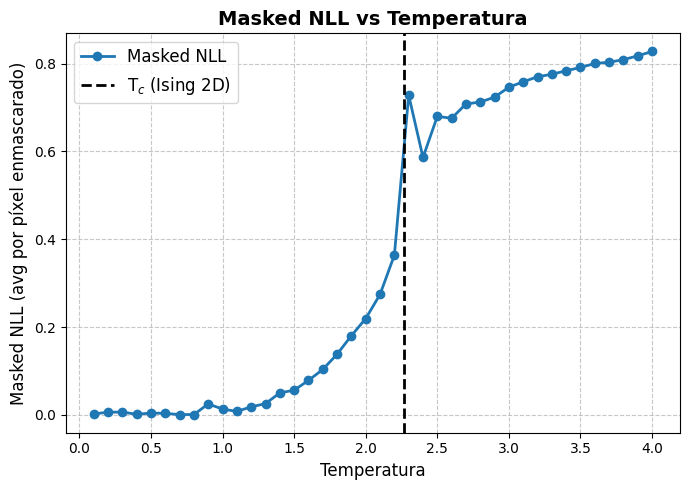

In [ ]:
# Solo masked NLL y v line en Tc: evaluación por temperatura
import os
import numpy as np
import torch
import torch.nn.functional as F
from collections import defaultdict
import matplotlib.pyplot as plt
from utils import read_ising_file

model.eval()
folder = './../data/data_30/'   # ajusta si hace falta

# Parámetros de máscara (mismo esquema que en train_epoch)
pct_mask = 0.05
seed = 42
eps = 1e-8

# Contenedor por temperatura (solo NLL)
metrics_per_temp = defaultdict(lambda: defaultdict(list))

sample_global_idx = 0  # contador global de muestras para semilla reproducible

for file in os.listdir(folder):
    if 'ising_' not in file:
        continue

    path = os.path.join(folder, file)
    try:
        ising = read_ising_file(path)
        temp = ising.metadata.get('T', None)
        spins = ising.load_all_spins(invert=False)  # lista o array de (H,W) o (N,H,W)

        # asegurar numpy array
        spins = np.array(spins, dtype=np.float32)

        # normalizar a batch
        if spins.ndim == 2:
            spins = spins[np.newaxis, ...]

        B = spins.shape[0]
        H, W = spins.shape[1], spins.shape[2]
        n_total = H * W

        # convertir a tensores en device
        x = torch.tensor(spins, dtype=torch.float32, device=next(model.parameters()).device)  # -1/+1
        y = (x + 1.0) / 2.0   # target prob 0/1
        x = x.unsqueeze(1)    # (B,1,H,W)
        y = y.unsqueeze(1)    # (B,1,H,W)

        with torch.no_grad():
            # Para cada muestra generamos máscara aleatoria igual que en train
            mask_obs = torch.empty((B,1,H,W), device=x.device)
            for i in range(B):
                # reproducible por muestra: seed + sample_global_idx + i
                g = torch.Generator(device='cpu')
                g.manual_seed(seed + sample_global_idx + i)
                # sample uniform and threshold
                rand = torch.rand((H, W), generator=g)
                mask_obs[i,0] = (rand > pct_mask).float()

            # preparar input: channel0 = state masked, channel1 = mask
            state_masked = y * mask_obs
            model_input = torch.cat([state_masked, mask_obs], dim=1)  # (B,2,H,W)

            # forward
            logits = model(model_input)          # (B,1,H,W)
            # masked elementwise BCE (NLL)
            loss_mat = F.binary_cross_entropy_with_logits(logits, y, reduction='none')  # (B,1,H,W)
            mask_eval = (1.0 - mask_obs)  # evaluar donde está enmascarado

            # sumar por muestra y normalizar por número de píxeles enmascarados
            loss_sum = (loss_mat * mask_eval).view(B, -1).sum(dim=1).cpu().numpy()
            n_masked_vec = mask_eval.view(B, -1).sum(dim=1).cpu().numpy()

            # acumular métricas normalizadas por píxel enmascarado por temperatura
            for j in range(B):
                nm = float(n_masked_vec[j]) if n_masked_vec[j] > 0 else 1.0
                # Fix: metrics_per_temp[temp] is defaultdict(list), so access ['nll'] always creates a list
                metrics_per_temp[temp]['nll'].append(loss_sum[j] / nm)

        sample_global_idx += B

    except Exception as e:
        # Ajuste: Imprime error exactamente como en el prompt
        print(f"Skipping {file}: {e}")
        continue

# Agregar por temperatura (media)
temps_sorted = sorted(metrics_per_temp.keys())
if len(temps_sorted) == 0:
    raise RuntimeError("No temperature buckets found. Revisa carpeta y read_ising_file.")

temps = np.array(temps_sorted)
mean_nll = np.array([np.mean(metrics_per_temp[T]['nll']) for T in temps_sorted])

# Temperatura crítica 
Tc = 2.0 / np.log(1 + np.sqrt(2))



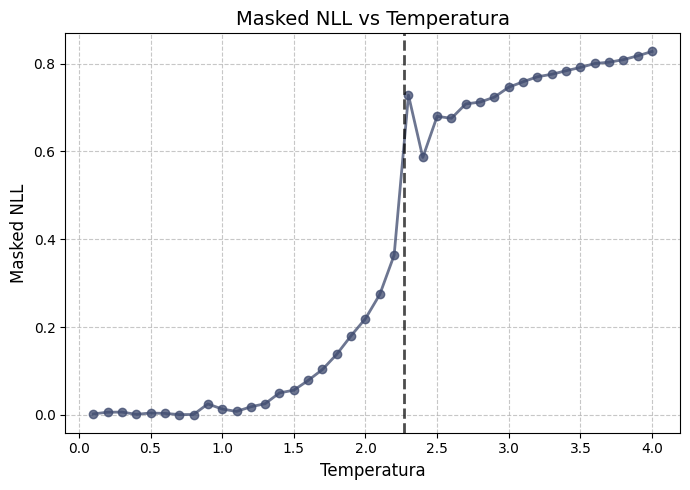

In [17]:
# Temperatura crítica 
Tc = 2.0 / np.log(1 + np.sqrt(2))

# Graficar Masked NLL 
plt.figure(figsize=(7,5))
plt.plot(temps, mean_nll, marker='o', linestyle='-', linewidth=2, color="#3f4b6f", alpha=0.76)
plt.axvline(x=Tc, color='k', linestyle='--', linewidth=2, label=r'T$_c$', alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Temperatura', fontsize=12)
plt.ylabel('Masked NLL', fontsize=12)
plt.title('Masked NLL vs Temperatura', fontsize=14)
plt.tight_layout()
os.makedirs('../img_results', exist_ok=True)
plt.savefig('../img_results/inpainting_masked_nll_vs_temperature.png', dpi=300, bbox_inches='tight')
plt.show()

## Guardar modelo 


In [ ]:
import os
import torch

# Crear carpeta usando rutas configuradas
save_dir = os.path.join(EXPERIMENTS_BASE, 'unet_ising_30')
os.makedirs(save_dir, exist_ok=True)
print(f"📁 Guardando modelo en: {save_dir}")

# Path del archivo
model_path = os.path.join(save_dir, "model.pt")

# Guardar el checkpoint
torch.save({
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "hyperparams": {
        "n_channels": 2,
        "out_channels": 1,
        "lr": 1e-3,
        "loss_fn": "BCEWithLogitsLoss",
        "architecture": "UNetIsing",
    }
}, model_path)

# Metadata
import yaml

# Configuración del modelo
config = {
    "model": {
        "architecture": "UNetIsing",
        "n_channels": 2,
        "out_channels": 1,
        "encoder_channels": [64, 128, 256, 512],
        "decoder_channels": [256, 128, 64]
    },
    "training": {
        "optimizer": "Adam",
        "lr": 1e-3,
        "loss": "BCEWithLogitsLoss"
    },
    "experiment": {
        "name": "unet_ising",
        "save_dir": "./experiments/unet_ising",
        "v":2
    }
}

# Guardar YAML
yaml_path = os.path.join(save_dir, "config.yaml")
with open(yaml_path, "w") as f:
    yaml.dump(config, f, sort_keys=False)

print(f"config.yaml guardado en: {yaml_path}")
